# Part 3B: MNIST CNN with scikit‑learn (via SciKeras)

_Author: Suyog Garg_, _Dated: 2025/11/18_



`scikit-learn` doesn’t implement CNNs natively, so we use the **SciKeras** wrapper to expose a Keras
model through the familiar `fit/score` API (and GridSearchCV). This still runs with TensorFlow under the hood.


## Environment

In [1]:
import os, sys, time, json, pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

print("TensorFlow:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

TensorFlow: 2.20.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]



## Dataset & preprocessing

We use **MNIST** (28×28 grayscale digits, 10 classes). Input is normalized to `[0, 1]`
and reshaped to `(N, 28, 28, 1)` for CNNs. Labels are integers `0..9`.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate([x_train, x_test]).astype("float32")/255.0
y = np.concatenate([y_train, y_test]).astype("int64")
x = np.expand_dims(x, -1)

Xtr, Xte, ytr, yte = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
def make_model(learning_rate=1e-3):
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [4]:
clf = KerasClassifier(model=make_model, epochs=5, batch_size=128, verbose=0)
# Optional: quick hyperparam search (tiny grid for demo)
param_grid = {"model_learning_rate":[1e-3, 5e-4]}
t0=time.perf_counter()
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, n_jobs=1)
grid.fit(Xtr, ytr)
train_time=time.perf_counter()-t0

print("Best params:", grid.best_params_)
y_pred = grid.predict(Xte)
test_acc = accuracy_score(yte, y_pred)
print("Test accuracy:", test_acc)

Best params: {'model__learning_rate': 0.0005}
Test accuracy: 0.9882857142857143


## Plot training history (from the best estimator)

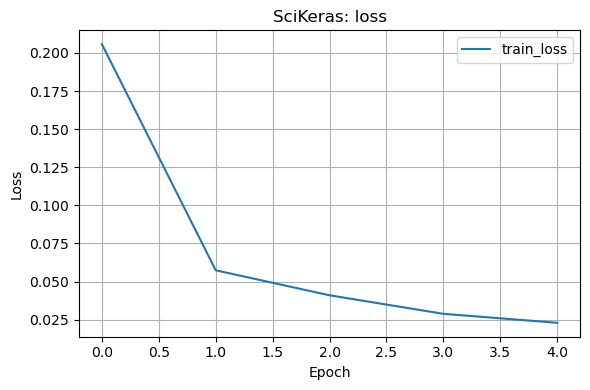

In [5]:
best = grid.best_estimator_
hist = best.model_.history.history if hasattr(best.model_, "history") else None
if hist:
    plt.figure(figsize=(6,4))
    if "loss" in hist: plt.plot(hist["loss"], label="train_loss")
    if "val_loss" in hist: plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.title("SciKeras: loss")
    plt.tight_layout()
    plt.savefig("artifacts/sklearn_loss.png", dpi=150)
    plt.show()

## Save metrics

In [6]:
# Utility: save artifacts (plots & metrics)
import os, json, pathlib, time
ART = pathlib.Path("artifacts")
ART.mkdir(exist_ok=True)

In [7]:
def save_metrics(name, **metrics):
    path = ART / f"{name}_metrics.json"
    with open(path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Saved:", path)

def effective_loc(*funcs):
    import inspect
    n = 0
    for f in funcs:
        try:
            src = inspect.getsource(f)
            for line in src.splitlines():
                s = line.strip()
                if s and not s.startswith("#"):
                    n += 1
        except Exception:
            pass
    return n

In [8]:
params = best.model_.count_params() if hasattr(best, "model_") else None
save_metrics("sklearn", framework="scikit-learn+scikeras", test_accuracy=float(test_acc),
             test_loss=float("nan"), train_time_sec=float(train_time), params=int(params or 0),
             epochs=int(len(hist["loss"])) if hist else 0,
             device=str(tf.config.list_physical_devices("GPU") or tf.config.list_physical_devices("CPU")),
             effective_loc=int(effective_loc(make_model)))
print("Saved artifacts/ and metrics.")

Saved: artifacts/sklearn_metrics.json
Saved artifacts/ and metrics.
